In [9]:
import numpy as np
import os
import torch
import random
from Experiment_new_new import Experiment
from plotting import plot_metrics_separately, plot_metrics_together
from utils import save_experiment, get_auc_summary

In [10]:
# Parameters

# Not changing
batch_size = 1
min_number_images = 20 # Minimum number of cell images allowed for a sample to be considered

# Dataset 
balanced = 0 # 0: Load the imbalanced dataset / 1: Toggle the balanced dataset
moderate_anaem = 0

# Multiple Instance Learning Related
aggregation = 'max' # Toggle among 'max', 'mean', 'attention'
bag_size = 20 # Amount of images (randomly picked samples) per bag used in each epoch / 0: All images 

# Less overfitting
dropout = 0.2 # Change the probability % of dropping out nodes

# Imbalanced dataset related
class_weight = 0 # Toggle to 1 to apply positive weight as a means to tackle imbalanced data
oversamplings = 1 # 0: No oversampling / 1: Random resampling of smaller class with replacement, 2: SMOTE

# Data augmentation related
img_dim = 128
apply_augmentation = 1

# Define the train, validation, and test ratios (e.g., 70%, 15%, 15%)
train_ratio = 0.67
test_ratio = 0.33

# Learning rate
lr=0.000001
epochs=100

# Freeze seed
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [11]:
# Define the directories

# Get current directory
current_directory = os.getcwd()

# Relative directory of images

if balanced == 1:
    if moderate_anaem == 1:
        other_string = "RCM_cells_cleaned_copy_balanced_bw"
#    else: 
#        other_string = "RCM_binary_cells_clean_no_moderate_mild_20filter_balanced"

else:
    if moderate_anaem == 1:
        other_string = "RCM_cells_cleaned_copy"
    else: 
       other_string = "RCM_cells_cleaned_no_malaria_anaemia_cases"

# Combine directpries
new_path = os.path.join(current_directory, other_string)

print(new_path)

/home/fabspace/Documents/EzerM/Malaria_FYP/malaria-detection-in-blood-samples-main/RCM_cells_cleaned_no_malaria_anaemia_cases


In [12]:
seeds = [42, 105, 4, 21] # 42, 105, 4, 21
exp=[]
train_accuracy_list_tracker = []
test_accuracy_list_tracker=[]
test_f1_tracker_list=[]
test_roc_auc_tracker_list=[]
test_pr_auc_tracker_list=[]
cnf_matrix_list=[]
plots=[]
diagn_distr_list=[]
diagnosis_pred_distr_list=[]
preds_record_list=[]

In [13]:
# Check if GPU is available and print in what device training will take place
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('This will run on', device)

This will run on cuda


In [14]:
# torch.cuda.empty_cache()

In [15]:
# print(torch.cuda.memory_summary(device=device, abbreviated=None))

In [ ]:
for i in range(len(seeds)):
        
        # Freeze seed
        np.random.seed(seeds[i])
        torch.manual_seed(seeds[i])
        random.seed(seeds[i])

        exp= Experiment(seeds[i],
                        img_dim,
                        new_path,
                        min_number_images,
                        train_ratio,
                        batch_size,
                        apply_augmentation,
                        oversampling=oversamplings,
                        class_weight=class_weight,
                        dropout=dropout,
                        aggregation=aggregation,
                        lr=lr,
                        )

        counts = exp.get_class_counts()

        diagn_distr_list.append(exp.get_loader_diagnosis_distribution())

        exp.train(epochs=epochs, bag_size = bag_size, class_weight=class_weight)
        
        train_accuracy_list, test_accuracy_list, test_f1_tracker, test_roc_auc_tracker, test_pr_auc_tracker, cnf_matrix, diagnosis_pred_distr, preds_record = exp.return_metrics()

        exp.plot_metrics()
        exp.plot_cnf()
        
        train_accuracy_list_tracker.append(train_accuracy_list)
        test_accuracy_list_tracker.append(test_accuracy_list)
        test_f1_tracker_list.append(test_f1_tracker)
        test_roc_auc_tracker_list.append(test_roc_auc_tracker)
        test_pr_auc_tracker_list.append(test_pr_auc_tracker)
        cnf_matrix_list.append(cnf_matrix)     
        diagnosis_pred_distr_list.append(diagnosis_pred_distr)
        preds_record_list.append(preds_record)

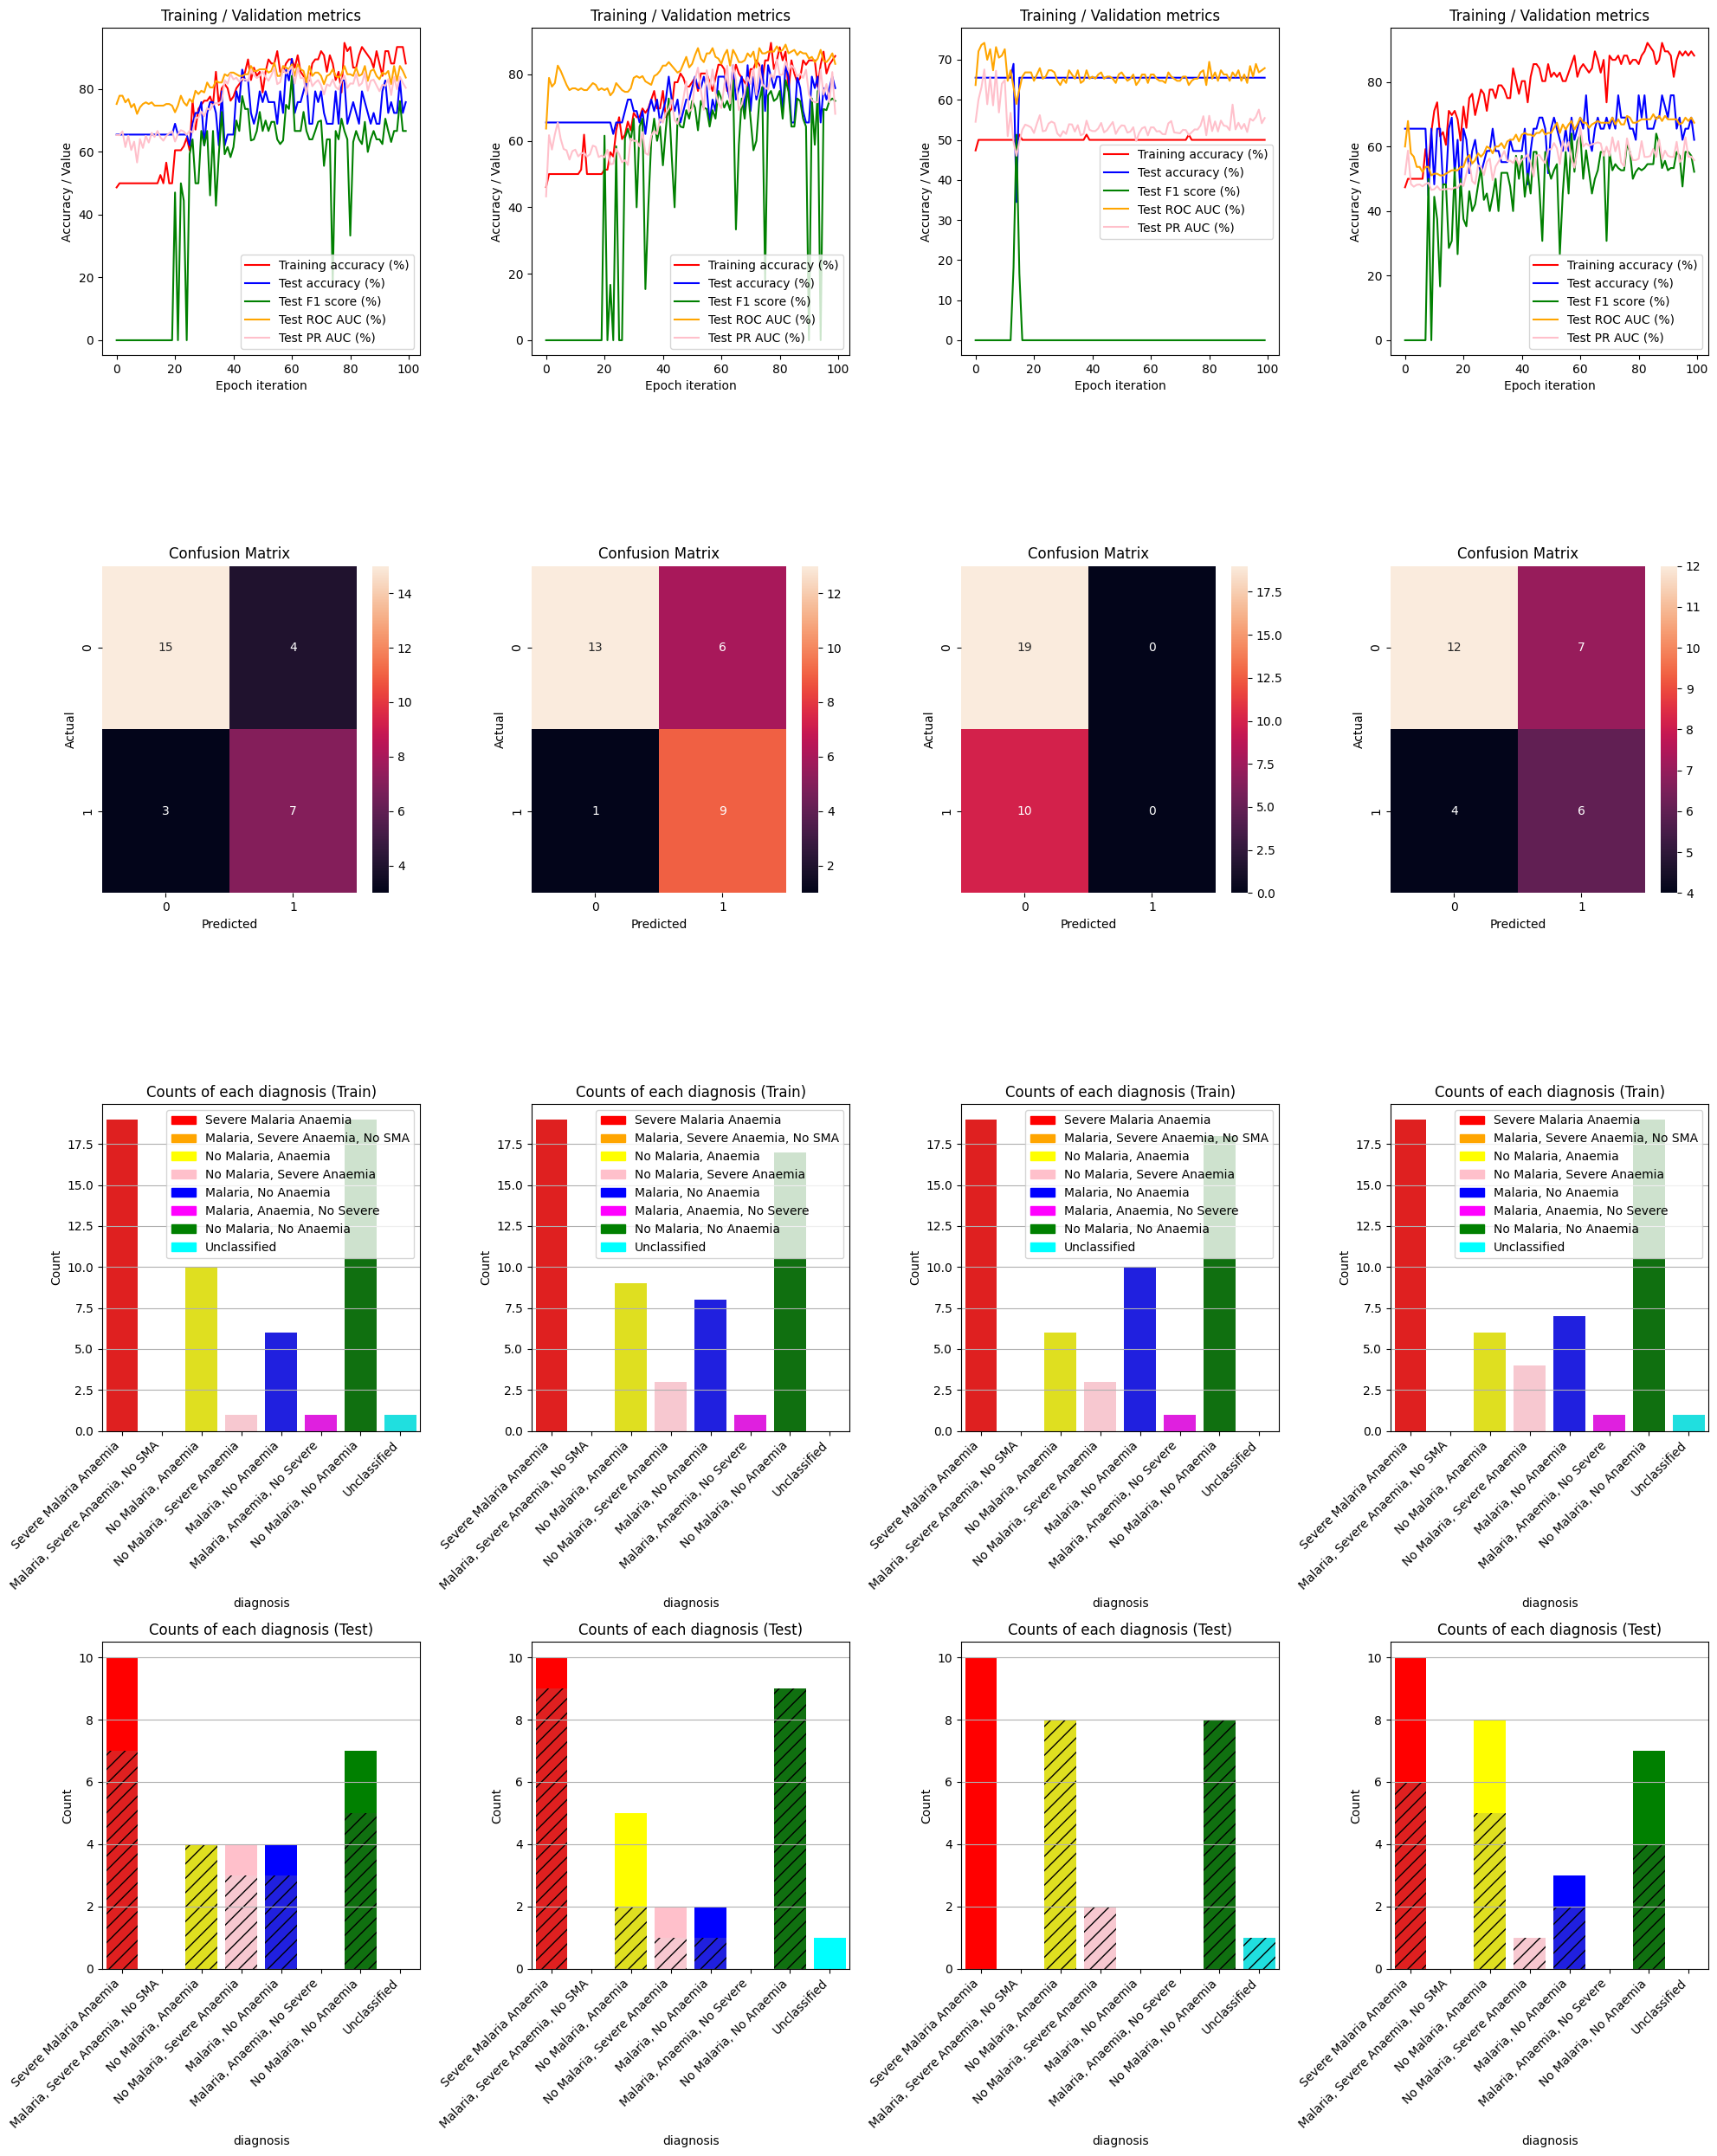

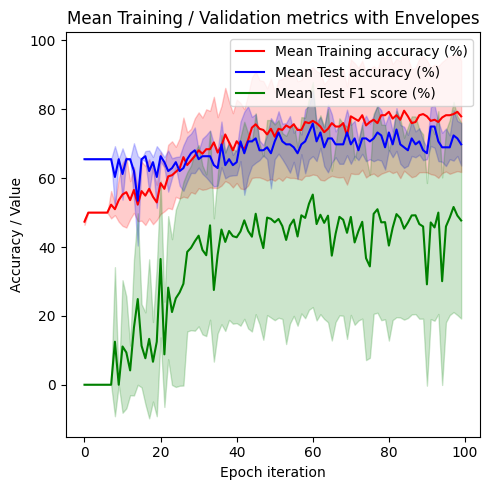

Mean ROC AUC:  75.52631578947368
Std ROC AUC :  7.899121589370335
Mean PR AUC :  64.93427405927406
Std PR AUC  :  10.294774133317377


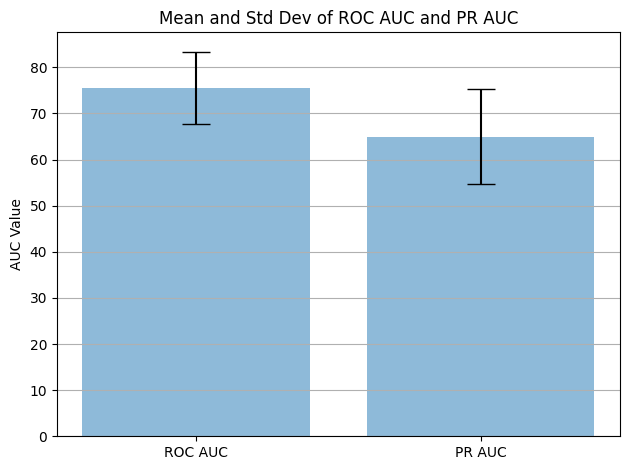

In [17]:
# Plot the output plots

# Metric figures and confusion matrix
fig_all_metrics = plot_metrics_separately(train_accuracy_list_tracker,test_accuracy_list_tracker,test_f1_tracker_list,test_roc_auc_tracker_list,test_pr_auc_tracker_list, cnf_matrix_list=cnf_matrix_list, diagn_dist_list=diagn_distr_list, diagnosis_pred_distr_list=diagnosis_pred_distr_list)
fig_all_together = plot_metrics_together(train_accuracy_list_tracker,test_accuracy_list_tracker,test_f1_tracker_list)

# Handling AUCs:
test_roc_auc_all_mean, test_roc_auc_all_std, test_pr_auc_all_mean, test_pr_auc_all_std, fig = get_auc_summary(test_roc_auc_tracker_list, test_pr_auc_tracker_list, seeds)


Save / Log the experiment inputs and outputs

In [18]:
####### Log the Experiment inputs and outputs #######

# Convert each numpy array to a list of lists

cnf_matrices = [array.tolist() for array in cnf_matrix_list]

save_experiment(batch_size,
        min_number_images,
        balanced,
        bag_size,
        aggregation,
        dropout,
        class_weight,
        oversamplings,
        apply_augmentation,
        train_ratio,
        test_ratio,
        lr,
        epochs,
        counts,
        train_accuracy_list_tracker,
        test_accuracy_list_tracker,
        test_f1_tracker_list,
        test_roc_auc_tracker_list,
        test_pr_auc_tracker_list,
        test_roc_auc_all_mean,
        test_roc_auc_all_std,
        test_pr_auc_all_mean,
        test_pr_auc_all_std,
        fig_all_metrics,
        fig_all_together,
        seeds,
        cnf_matrices,
        fig,
        img_dim,
        moderate_anaem,
        preds_record_list
        )